In [24]:
import sys
sys.path.append('/Users/victor/Documents/code/nba_api')

import re
import pandas as pd
import numpy as np

from src.espn_scraper import espn_player_scraper
from src.player_stat import get_player_stat, NoDataError

from sqlalchemy import create_engine
from tqdm import tqdm_notebook
from nba_py import player
from time import sleep
import scipy as sp
import seaborn as sns

## Reading in the data

In [76]:
engine = create_engine("sqlite:///db/nba.db", echo=False)
with engine.connect() as conn:
    stat = pd.read_sql('stat', conn, index_col='nba_id')
    position = pd.read_sql('players', conn, index_col='nba_id')

In [77]:
stat.head()

,shot_res,shot_in_paint,shot_mid_range,shot_lcorner_3,shot_rcorner_3,shot_above_3,fga,block_res,block_in_paint,block_mid_range,block_lcorner_3,block_rcorner_3,block_above_3,blka,oreb,dreb,ast,stl,min
nba_id,,,,,,,,,,,,,,,,,,,
203382,0.515695,0.125561,0.085202,0.022422,0.026906,0.224215,223,0.749999,0.250000,0.000000,0.000000,0.000000,0.000000,12,9.3,18.7,6.3,1.4,2305.288333
1627759,0.367424,0.156566,0.127525,0.032828,0.064394,0.251263,792,0.674418,0.279070,0.000000,0.000000,0.023256,0.023256,43,3.1,12.4,5.0,3.3,4065.096667
1628408,0.333333,0.190476,0.095238,0.000000,0.095238,0.285714,21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,5.7,25.5,4.7,1.9,54.031667
202330,0.261417,0.157480,0.218898,0.050394,0.059843,0.251968,635,0.629629,0.259259,0.037037,0.037037,0.000000,0.037037,27,1.3,16.1,6.3,1.6,1868.588333
201143,0.285319,0.198061,0.235457,0.012465,0.016620,0.252078,722,0.586207,0.379310,0.034483,0.000000,0.000000,0.000000,29,5.1,17.2,14.0,2.3,4249.708333


In [78]:
position.head()

,name,position,espn_player_id,url
nba_id,,,,
203382,aron baynes,C,2968439,http://www.espn.com/nba/player/_/id/2968439/ar...
1627759,jaylen brown,SG,3917376,http://www.espn.com/nba/player/_/id/3917376/ja...
1628408,pj dozier,PG,3923250,http://www.espn.com/nba/player/_/id/3923250/pj...
1626780,jonathan gibson,PG,2234666,http://www.espn.com/nba/player/_/id/2234666/jo...
202330,gordon hayward,SF,4249,http://www.espn.com/nba/player/_/id/4249/gordo...


In [80]:
data = stat.join(position[['position']])

In [81]:
data.head()

,shot_res,shot_in_paint,shot_mid_range,shot_lcorner_3,shot_rcorner_3,shot_above_3,fga,block_res,block_in_paint,block_mid_range,block_lcorner_3,block_rcorner_3,block_above_3,blka,oreb,dreb,ast,stl,min,position
nba_id,,,,,,,,,,,,,,,,,,,,
1713,0.167742,0.066667,0.094624,0.049462,0.066667,0.554839,465,0.555555,0.111111,0.222222,0.0,0.0,0.111111,9,1.9,12.0,6.3,3.6,2356.346667,SF
1717,0.013333,0.072000,0.370667,0.013333,0.042667,0.488000,375,0.000000,0.999995,0.000000,0.0,0.0,0.000000,2,0.9,19.7,5.1,1.6,2695.478333,PF
2037,0.050459,0.162844,0.327982,0.050459,0.034404,0.373853,436,0.125000,0.250000,0.624999,0.0,0.0,0.000000,8,0.9,5.4,14.5,2.5,2864.170000,SG
2199,0.909091,0.070707,0.010101,0.000000,0.000000,0.010101,99,0.499999,0.333333,0.166666,0.0,0.0,0.000000,6,10.2,23.0,3.9,2.4,1660.493333,C
2200,0.382979,0.255319,0.223404,0.021277,0.010638,0.106383,94,0.666666,0.333333,0.000000,0.0,0.0,0.000000,6,2.9,31.1,10.1,0.7,390.961667,C


## EDA

In [82]:
# Getting distribution of class labels
data.position.value_counts()

SG    114
PG    101
PF     96
SF     93
C      71
F       5
G       4
Name: position, dtype: int64

The Forward(F) and Guard(G) should really be explicitly defined. For instance, as either Point Guard (PG) or Shooting Guard (SG). 

Since there are not many observations, I'm just going to make a quick and easy assumption that all Fowards are Small Forwards, and Guards are Point Guards.

Also note we are dealing with slightly imbalanced classes here

In [83]:
data.loc[data.position == "G",'position'] = 'PG'
data.loc[data.position == "F",'position'] = 'SF'

In [84]:
data.position.value_counts(normalize=True)

SG    0.235537
PG    0.216942
SF    0.202479
PF    0.198347
C     0.146694
Name: position, dtype: float64

#### Checking distribution of Field Goal Attempts

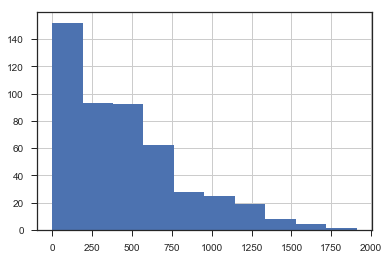

In [85]:
data.fga.hist()

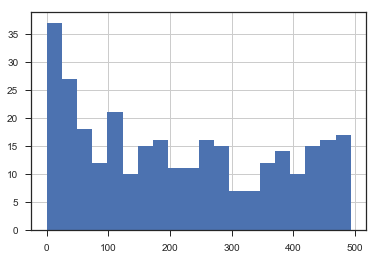

In [86]:
# Explore the lower end
data.loc[data.fga < 500, 'fga'].hist(bins=20)

A lot of players have less than 25 shots. We will drop them as they haven't really played enough for their position to show through the data

#### Checking Distribution of Block Attempts

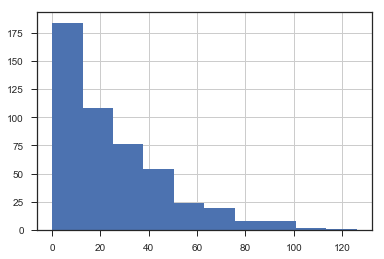

In [87]:
data.blka.hist()

### Spliting Data

In [88]:
from sklearn.model_selection import train_test_split

X = data.drop('position', axis=1)
y = data[['position']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [89]:
X_train.head()

,shot_res,shot_in_paint,shot_mid_range,shot_lcorner_3,shot_rcorner_3,shot_above_3,fga,block_res,block_in_paint,block_mid_range,block_lcorner_3,block_rcorner_3,block_above_3,blka,oreb,dreb,ast,stl,min
nba_id,,,,,,,,,,,,,,,,,,,
1626246,0.623077,0.242308,0.096154,0.000000,0.015385,0.023077,260,0.666666,0.333333,0.000000,0.0,0.0,0.000000,18,11.1,25.3,8.8,1.9,985.641667
203992,0.210465,0.190698,0.169767,0.023256,0.026744,0.379070,860,0.435897,0.410256,0.102564,0.0,0.0,0.051282,39,1.7,9.2,12.3,3.4,4122.325000
203085,0.260946,0.148862,0.019264,0.073555,0.056042,0.441331,571,0.750000,0.166667,0.041667,0.0,0.0,0.041667,24,1.1,5.9,7.9,2.1,3372.618333
1626220,0.375740,0.088757,0.029586,0.115385,0.121302,0.269231,338,0.578947,0.368421,0.052632,0.0,0.0,0.000000,19,1.6,16.4,7.6,3.1,2820.656667
1626174,0.495726,0.205128,0.076923,0.008547,0.034188,0.179487,117,0.599999,0.399999,0.000000,0.0,0.0,0.000000,5,6.6,25.4,3.0,3.1,439.078333


A big chunk of players do not have meaningful number of blocks. We will keep this feature for now and see if the models think they are important later

## Multinomial Logistic Regression

Why choose it
    - Predicts probability distribution over k classes, which gives us insight on how close the player is to each position/role
    - Performs well when data is not well separated, which is going to be the case for us. The variance in NBA stat is often quite high
    - Can handle weak multicolinearity. We will test with VIF(Variance Inflation Factor) to make sure this is the case, and do dimensionality reduction if there is strong covariance between independent variables (VIF > 5)


In [142]:
# Calculating VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = []
for idx, col in enumerate(X.columns):
    VIF_i = variance_inflation_factor(X.dropna().values, idx)
    vif_data.append([col, VIF_i])

display(pd.DataFrame(vif_data, columns=['Feature', "VIF"]).sort_values("VIF", ascending=False))

,Feature,VIF
6,fga,22.034299
7,block_res,17.660519
0,shot_res,17.400939
18,min,13.334424
13,blka,12.238345
15,dreb,10.367670
14,oreb,9.729501
5,shot_above_3,9.153783
17,stl,7.923262
1,shot_in_paint,7.108341


Anything with VIF over 5 exhibits strong multicolinearity with other features, here we are dealing with many feature that has strong correlation with others.

Many algorithms we could use, including logistic regression, SVM /w RFB Kernels & 

Quickest way to solve this is probably with PCA.

In [11]:
# After verifying that VIF checks out, move on to modeling

# We will standarize the features for regularization to be more meaningful. Otherwise Logistic
# Regression does not require normalization
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



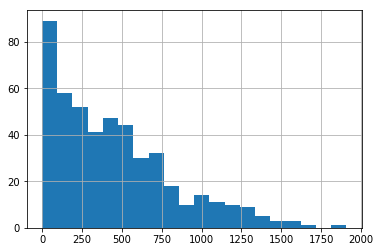

In [27]:
stat.fga.hist(bins=20)

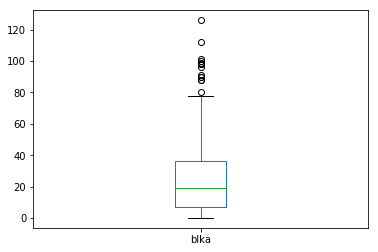

In [28]:
stat.blka.plot('box')